## 4.1 자세 추정 및 오픈포즈 개요

#### 4.1.1 자세 추정 개요
* 자세 추정
    * 이미지에 포함된 여러 인물을 탐지하여 **인체 각 부위의 위치를 식별**
    * **인체 각 부위를 연결하는 선(링크)**을 구함

#### 4.1.2 MSCOCO 데이터셋 및 자세 추정의 어노테이션 데이터
* MSCOCO
    * 이미지 데이터, 어노테이션 데이터가 있음
        * 어노테이션 데이터: JSON 형식
            * 이미지의 주요 인물 정보(`joint_self`)와 그 외 인물 정보(`joint_others`)로 나누어 저장
        * 동일한 이미지의 어노테이션에서 주요인물의 정보가 다를 수 있음
    * **캡션 어노테이션 데이터**가 있음
        * 해당 이미지가 무엇을 나타내는지 설명
        * 이미지에 캡션 데이터를 생성하는 딥러닝 데이터셋으로 활용
    * MSCOCOC 중 **인물이 있고, 인체의 부위와 인물의 어노테이션이 부여된 데이터 사용**
    * MSCOCO 자세 추정용 데이터: COCO Keypoint Detection Task(COCO 키포인트 인식 작업에 사용)

#### 4.1.3 오픈포즈를 활용한 자세 추정 흐름
* 본질적인 내용은 시맨틱 분할과 거의 비슷!
    * 이미지에서 픽셀 수준으로 클래스(신체 부위) 판정
    * 시맨틱 분할
        * 픽셀별 클래스 분류 문제
    * 오픈포즈
        * 픽셀별 회귀문제
        
        
* 신체부위끼리 어떻게 연결할까,,?!
    * 하향식 접근 방식
        * 물체감지로 인물을 검출 → 한 사람의 이미지만 잘라서 자세 추정
        * 이미지에서 한 사람만 추출되기 때문에 어느 쌍으로 연결할지 문제 해결!
        * 인물이 많아지면 처리 시간 증가, 정밀도와 정확도에 영향을 끼치게 됨
    * **상향식 접근 방식**
        * OpenPose에서 사용하는 방식
        * 링크 쌍 문제를 해결하기 위해 **PAFs** 사용
            * 부위간 연결성을 나타내는 지표


* OpenPose를 활용한 자세 추정 3단계
    1. 전처리
        * 이미지 사이즈: 368⨉368
        * 색상정보 표준화
    2. 신경망에 전처리한 이미지 입력
        * 출력: 부위(19⨉368⨉368)배열과 PAFs(38⨉368⨉368)배열
        * 출력 배열의 값은 각 픽셀이 각 클래스일 신뢰도에 대응
    3. 신체 부위의 출력 결과에서 각 부위별 좌표를 정함<br> PAFs 정보와 함께 링크를 구함<br> 이미지 크기 원 상태로

## 4.2 데이터셋과 데이터 로더 구현


#### 4.2.1 마스크 데이터란
* 이미지에 사람이 있지만 어노테이션 데이터가 없는 상태는 자세 추정 학습에 좋지 않음
    * 훈련 및 검증용 이미지에서 이미지에 존재하나 <br> 자세 어노테이션 데이터가 없는 인물정보는 검게 칠하는 마스크를 적용
* 손실함수 계산시 신체 부위로 검출된 좌표 위치에 마스크된 픽셀의 결과를 손실 계산에서 무시함!!

#### 4.2.2 폴더 준비

In [17]:
import os
import urllib.request
import zipfile
import tarfile

In [18]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [19]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [23]:
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)
    zip.close()  

In [24]:
# mask.tar.gz 압축풀기
save_path = os.path.join(data_dir, "mask.tar.gz") 

with tarfile.open(save_path, 'r:*') as tar:
    tar.extractall(data_dir)

#### 4.2.3 화상 데이터, 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성

In [25]:
# 패키지import
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

In [26]:
def make_datapath_list(rootpath):
    """
    학습 및 검증의 이미지 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성
    """

    # 어노테이션의 JSON파일 읽기
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # index 저장
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 이미지 파일 경로 저장
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # 마스크 데이터 경로 저장
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_tarin2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # 어노테이션 데이터 저장
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [27]:
# 동작 확인(실행은 10초 정도 걸린다.)
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

#### 4.2.4 마스트 데이터 동작 확인
* 야구 이미지와 마스트 데이터 표시

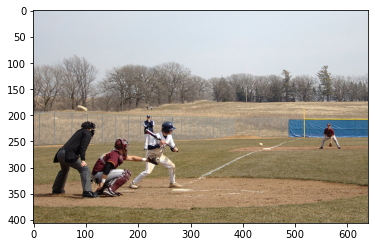

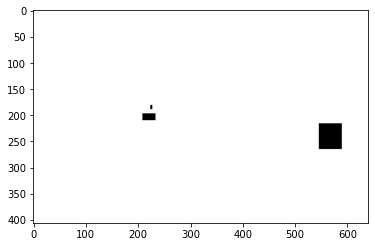

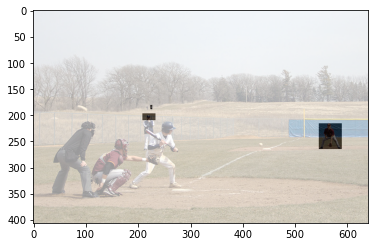

In [28]:
index = 24

# 이미지
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 마스크
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 합성
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


#### 4.2.5 이미지 전처리 작성
* `DataTransform`
    * 이미지와 어노테이션을 전처리
    * 이미지 데이터, 어노테이션 데이터, 마스크 데이터를 세트로 변환
    

In [31]:
# 데이터 처리 클래스와 데이터 확장 클래스 import 
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    """
    이미지와 마스크, 어노테이션 전처리 클래스
    학습 시 추론 시 서로 다르게 동작
    학습 시에는 데이터 확장 수행
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSON에서 어노테이션을 사전에 저장
                add_neck(),  # 어노테이션 데이터의 순서 변경 및 목의 어노테이션 데이터 추가
                aug_scale(),  # 확대 축고
                aug_rotate(),  # 회전
                aug_croppad(),  # 자르기
                aug_flip(),  # 좌우반전
                remove_illegal_joint(),  # 이미지에서 밀려나온 아노테이션 제거
                # Normalize_Tensor()  # 색상 정보의 표준화 및 텐서화
                no_Normalize_Tensor()  # 여기서는 색상 정보의 표준화 생략
            ]),
            'val': Compose([
                # 검증 생략
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss

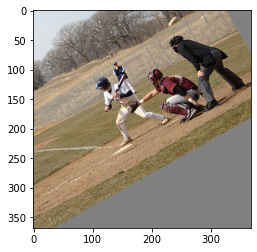

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


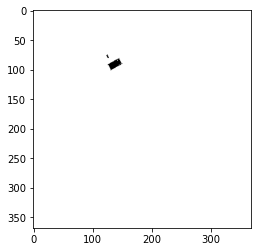

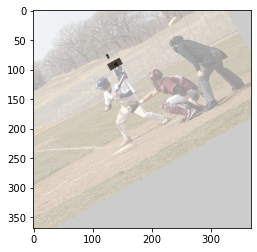

In [32]:
# 동작확인
# 이미지 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 이미지 전처리
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

# 이미지 표시
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# 마스크 표시
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 합성 RGB 정보 갖추기
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

#### 4.2.6 훈련 데이터의 정답 정보로 사용할 어노테이션 데이터 작성
* 히트맵
* PAFs
    * 한 관절(Joint)에서 다른 관절로 이어지는 방향을 인코딩한 2D벡터,,,
    * 관절이 연결된 정보를 가지고 있음 
    * 누구의 관절인지 파악하는데 사용!

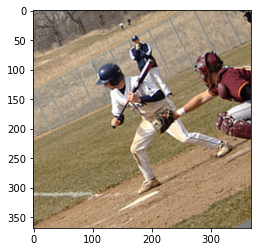

In [33]:
# SciPy가 없어서 Prompt에서 설치했음
from utils.dataloader import get_ground_truth

# 이미지 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 이미지 전처리
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPose의 어노테이션 데이터 생성
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 원래 이미지
plt.imshow(img)
plt.show()

In [34]:
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

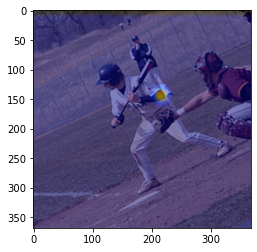

In [35]:
# 왼쪽 팔꿈치의 히트맵 확인

# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 주의: 히트맵의 이미지 크기가 1/8로 되어 있어 확대한다.

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


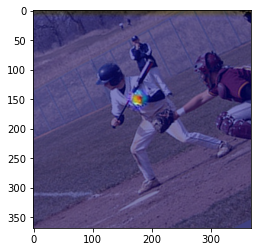

In [36]:
# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


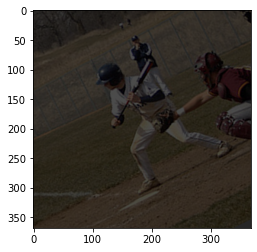

In [37]:
# 왼쪽 팔꿈치와 왼쪽 손목의 PAF 확인
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x벡터의 PAF

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()


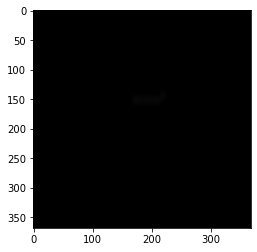

In [38]:
# PAF만 표시
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x벡터의 PAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)

#### 4.2.7 데이터셋 작성
* `COCOkeypointsDataset`
    * 마스크부분
        * 무시할 부분: 0, 그렇지 않은 부분: 1

In [39]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCO Cocokeypoints의 데이터셋을 작성하는 클래스. 파이토치 데이터셋 클래스 상속

    Attributes
    ----------
    img_list : 리스트
        이미지
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''이미지 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''이미지의 텐서 형식 데이터, 어노테이션, 마스크 획득'''

        # 1. 이미지 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]

        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]

        # 3. 이미지 전처리
        meta_data, img, mask_miss = self.transform(
            self.phase, meta_data, img, mask_miss)

        # 4. 정답 어노테이션 데이터 획득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. 마스크 데이터는 RGB가 (1, 1, 1)또는 (0, 0, 0)이므로 차원을 낮춘다.
        # 마스크된 위치는 값이 0, 그렇지 않으면 1
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. 채널이 맨 끝에 있어 순서 변경
        # 예：paf_mask：torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask


In [40]:
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# 데이터 꺼내기 예시
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


#### 4.2.8 데이터 로더 작성
* 훈련 데이터와 검증 데이터 각각의 DataLoader를 작성하여 사전형 변수로 정리!

In [41]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복으로 변환
item = next(batch_iterator)  # 첫 번째 요소를 꺼낸다.
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask


torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


### 4.3 오픈포즈 네트워크 구성 및 구현
* 오픈포즈 네트워크
    * Feature 모듈과 6개의 Stage로 구성되어 있음

In [42]:
# 패키지 import
import torch
import torch.nn as nn
from torch.nn import init
import torchvision

In [43]:
class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()

        # Feature 모듈
        self.model0 = OpenPose_Feature()

        # Stage 모듈
        # PAFs측
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')

        # confidence heatmap 측
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')

    def forward(self, x):
        """순전파 정의"""

        # Feature 모듈
        out1 = self.model0(x)

        # Stage1
        out1_1 = self.model1_1(out1)  # PAFs측
        out1_2 = self.model1_2(out1)  # confidence heatmap측

        # CStage2
        out2 = torch.cat([out1_1, out1_2, out1], 1)  # 1차원 채널 결합
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)

        # Stage3
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)

        # Stage4
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)

        # Stage5
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)

        # Stage6
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        # 손실 계산을 위하여 각 스테이지 결과 계산
        saved_for_loss = []
        saved_for_loss.append(out1_1)  # PAFs 측
        saved_for_loss.append(out1_2)  # confidence heatmap 측
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        # 최종적인 PAFs의 out16_1과 confidence heatmap의 out6_2,
        # 손실 계산용으로 각 단계에서 PAFs와 히트맵을 저장한 saved_for_loss 출력
        # out6_1：torch.Size([minibatch, 38, 46, 46])
        # out6_2：torch.Size([minibatch, 19, 46, 46])
        # saved_for_loss:[out1_1, out_1_2, ・・・, out6_2]

        return (out6_1, out6_2), saved_for_loss

## 4.4 Feature 및 Stage 모듈 설명 및 구현
* Feature모듈
    * VGG-19의 열 번째 합성곱 층까지 구성을 그대로 사용
    * 출력
        * 128⨉46⨉46크기의 텐서

In [44]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()

        # VGG-19 최초 열 개의 합성곱을 이용
        # 처음 실행할 때는 학습된 파라미터를 다운로드하여 실행에 시간이 걸린다.
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        # VGG-19 최초 열 개의 합성곱 층까지
        # C3, ReLU, P의 총 개수: 23
        model['block0'] = vgg19.features[0:23]

        # 나머지는 새로운 합성곱 층을 두 개 준비
        model['block0'].add_module("23", torch.nn.Conv2d(
            512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("24", torch.nn.ReLU(inplace=True))
        model['block0'].add_module("25", torch.nn.Conv2d(
            256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("26", torch.nn.ReLU(inplace=True))

        self.model = model['block0']

    def forward(self, x):
        outputs = self.model(x)
        return outputs


#### 4.4.2 각 Stage 모듈의 블록 구성 및 구현
* Stage
    * 각 스테이지는 합성곱 층과 ReLU만으로 구성
    * Stage1과 Stage2~6의 합성곱 층 수나 종류는 다름
    * Stage1
        * 입력: 128⨉46⨉46
    * Stage2
        * 입력: 185⨉46⨉46
    
* block
    * block1
        * PAFs 출력
    * block2
        * 히트맵 출력
        
        
* `OpenPose_block`
    * 유닛 설정인 구성 설정
    * 구성 내용에 맞도록 합성곱 층과 ReLU 생성하고 리스트 변수 layers에 저장
    * 리스트 변수의 유닛 정보를 사용하여 `nn.Sequential()`클래스이 네트워크 모델 생성
    * 변수 net의 합성곱 층 가중치 초기화

In [45]:
def make_OpenPose_block(block_name):
    """
    구성 변수에서 오픈포즈 Stage 모듈의 블록 작성
    nn.Module이 아닌 nn.Sequential로 한다.
    """

    # 1. 구성의 사전형 변수 block를 작성하여 네트워크를 생성시킨다.
    # 먼저 모든 패턴의 사전을 준비하여 block_name인수만 생성한다.
    blocks = {}
    # Stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    # Stages 2 - 6
    for i in range(2, 7):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # block_name 인수의 구성 사전을 꺼낸다.
    cfg_dict = blocks[block_name]

    # 구성 내용을 리스트 변수 layers에 저장
    layers = []

    # 0번째부터 마지막 층까지 작성
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    # 3. layers를 Sequential로 한다.
    # 단 마지막에 ReLU는 필요 없어 직전까지 사용한다.
    net = nn.Sequential(*layers[:-1])

    # 4. 초기화 함수를 설정하여 합성곱 층을 초기화
    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    net.apply(_initialize_weights_norm)

    return net


In [46]:
# 모델 정의
net = OpenPoseNet()
net.train()

# batch Size 정의
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 계산
outputs = net(dummy_img)

In [47]:
print(outputs)

((tensor([[[[-3.1521e-05, -2.3014e-05, -3.9808e-05,  ..., -5.2379e-05,
           -1.9417e-05, -9.9944e-06],
          [-2.2314e-05, -3.1213e-06, -4.1437e-05,  ...,  3.2002e-06,
            4.8888e-07,  1.0323e-06],
          [-3.1434e-05, -3.2462e-06, -1.6645e-05,  ..., -2.0941e-05,
           -1.6180e-05, -2.2749e-05],
          ...,
          [-6.5461e-08, -3.7690e-05, -1.5286e-05,  ..., -6.1529e-05,
           -6.1723e-05, -5.6666e-05],
          [ 3.0476e-06, -2.8831e-05, -2.8679e-05,  ..., -3.9693e-05,
           -6.3081e-05, -5.0524e-05],
          [-6.6010e-06, -1.1005e-05, -3.8285e-05,  ..., -3.6788e-05,
           -2.2385e-05, -2.9143e-05]],

         [[ 6.3718e-05,  6.7834e-05,  8.2446e-05,  ...,  4.3438e-05,
            4.5635e-05,  4.2784e-05],
          [ 3.7198e-05,  7.6485e-05,  8.8985e-05,  ...,  6.0779e-05,
            5.0331e-05,  3.6276e-05],
          [ 3.7782e-05,  5.0503e-05,  1.1030e-04,  ...,  4.8670e-05,
            5.8401e-05,  5.0931e-05],
          ...,
   

## 4.5 텐서보드 X를 사용한 네트워크 시각화 기법

In [30]:
from utils.openpose_net import OpenPoseNet
# 모델 준비
net = OpenPoseNet()
net.train()

OpenPoseNet(
  (model0): OpenPose_Feature(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, ker

In [34]:
# # 1. 텐서보드X의 저장 클래스 호출
# from tensorboardX import SummaryWriter

# # 2. tbX 폴더에 저장할 writer 준비
# # tbX 폴더가 없으면 자동으로 생성
# writer = SummaryWriter("./tbX/")


# # 3. 네트워크에 넣을 더미 데이터 작성
# batch_size = 2
# dummy_img = torch.rand(batch_size, 3, 368, 368)

# # 4. 오픈포즈의 인스턴스 net에 더미 데이터인 dummy_img를 전달할 때 graph를 writer에 저장
# writer.add_graph(net, (dummy_img, ))
# writer.close()

# # 5. 명령 프롬프트를 열고 tbX가 있는 4_pose_estimation 폴더까지 이동
# # 다음 명령을 실행

# # tensorboard --logdir="./tbX/"

# # 이후、http://localhost:6006에 접근

## 4.6 오픈포즈 학습


#### 4.6.1 학습 시 주의점
* 손실함수의 정의

#### 4.6.2 데이터 로더 및 네트워크 작성
* 검증용 데이터 로더를 작성하지 않았기 떄문에 dictloaders_dict의 val을 None으로 설정

In [48]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [49]:
# 난수시드 설정
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [50]:
from utils.dataloader import make_datapath_list, DataTransform, COCOkeypointsDataset

# MSCOCO 파일 경로 리스트 작성 
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

# Dataset작성
# 데이터 양이 많아 책에서는 train을 val_list에서 작성하는 점에 주의
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())

# 간단한 학습을 진행하므로 검증 데이터를 작성하지 않는다.
# val_dataset = CocokeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# DataLoader작성
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader = data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수로 정리
# dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict = {"train": train_dataloader, "val": None}


In [51]:
# OpenPose_Net 클래스의 인스턴스 생성
from utils.openpose_net import OpenPoseNet
net = OpenPoseNet()

#### 4.6.3 손실함수 정의
* 오픈포즈 손실함수
    * 히트맵과 PAFs에 대해 정답 어노테이션 데이터과의 **회귀**오차
    * 픽셀 별 값을 회귀
    * `F.mse_loss()`: 평균 제곱 오차 함수 사용
    * 네트워크 모델 전체의 오차 = 각 스테이지의 히트맵과 PAFs의 모든 오차의 합
    * 자세 어노테이션이 없는 부분은 손실 계산 X
        * 각 스테이지에서 추정한 내용 모두 마스크를 곱함
            * 무시할 부분 값: 0, 그렇지 않은 부분 값: 1

In [52]:
# 손실함수 설정
class OpenPoseLoss(nn.Module):
    """OpenPose의 손실함수 클래스"""

    def __init__(self):
        super(OpenPoseLoss, self).__init__()

    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        """
        손실함수 계산

        Parameters
        ----------
        saved_for_loss : OpenPoseNet 촐력(리스트)

        heatmap_target : [num_batch, 19, 46, 46]
            정답 부위의 어노테이션 정보

        heatmap_mask : [num_batch, 19, 46, 46]
            heatmap 이미지의 mask

        paf_target : [num_batch, 38, 46, 46]
            정답 PAF의 어노테이션 정보

        paf_mask : [num_batch, 38, 46, 46]
            PAF 이미지의 마스크 

        Returns
        -------
        loss : 텐서
            손실 값
        """

        total_loss = 0
        # 스테이지마다 계산
        for j in range(6):

            # PAFs 및 히트맵에서 마스크된 부분(paf_mask = 0 등)은 무시
            # PAFs
            pred1 = saved_for_loss[2 * j] * paf_mask
            gt1 = paf_target.float() * paf_mask

            # heatmaps
            pred2 = saved_for_loss[2 * j + 1] * heat_mask
            gt2 = heatmap_target.float()*heat_mask

            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')

        return total_loss

criterion = OpenPoseLoss()

#### 4.6.4 학습실시


In [53]:
optimizer = optim.SGD(net.parameters(), lr=1e-2,
                      momentum=0.9,
                      weight_decay=0.0001)

* 학습하는데 필요한 함수 정의
    * `if imges.size()[0] == 1:` 파이토치에서 배치 사이즈가 1이 되면 오류 발생!

In [56]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPU를 사용할 수 있는지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용장치：", device)

    # 네트워크를 GPU로
    net.to(device)

    # 네트워크가 어느 정도 고정되면 고속화시킨다.
    torch.backends.cudnn.benchmark = True

    # 이미지 매수
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # 반복 카운터 설정
    iteration = 1

    # epoch루프
    for epoch in range(num_epochs):

        # 개장 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epoch손실 합
        epoch_val_loss = 0.0  # epoch손실 합

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch 훈련 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
                optimizer.zero_grad()
                print('（train）')

            # 이번에는 검증 생략
            else:
                continue
                # net.eval()   # 모델을 검증 모드로
                # print('-------------')
                # print('（val）')

            # 데이터 로더에서 미니 배치씩 꺼내는 루프
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하므로 피한다.
                if imges.size()[0] == 1:
                    continue

                # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다.
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # optimizer초기화
                optimizer.zero_grad()

                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train'):
                    # (out6_1, out6_2)는 사용하지 않으므로 _ 로 대체
                    _, saved_for_loss = net(imges)

                    loss = criterion(saved_for_loss, heatmap_target,
                                     heat_mask, paf_target, paf_mask)
                    del saved_for_loss
                    # 훈련 시에는 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 검증시
                    # else:
                        #epoch_val_loss += loss.item()

        # epoch의 phase별 손실과 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, 0))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 마지막 네트워크 저장
    torch.save(net.state_dict(), 'weights/openpose_net_' +
               str(epoch+1) + '.pth')

* 학습 실시

In [58]:
# 학습 및 검증을 실행한다
import time

startTime = time.time()
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

endTime = time.time()

사용장치： cuda:0
-------------
Epoch 1/2
-------------
（train）
반복 10 || Loss: 0.0017 || 10iter: 13.3808 sec.
반복 20 || Loss: 0.0014 || 10iter: 12.9261 sec.
반복 30 || Loss: 0.0016 || 10iter: 13.1536 sec.
반복 40 || Loss: 0.0016 || 10iter: 13.6049 sec.
반복 50 || Loss: 0.0014 || 10iter: 13.2137 sec.
반복 60 || Loss: 0.0016 || 10iter: 13.5531 sec.
반복 70 || Loss: 0.0016 || 10iter: 12.8273 sec.
반복 80 || Loss: 0.0014 || 10iter: 12.8873 sec.
반복 90 || Loss: 0.0014 || 10iter: 12.9511 sec.
반복 100 || Loss: 0.0017 || 10iter: 13.4702 sec.
반복 110 || Loss: 0.0015 || 10iter: 13.2141 sec.
반복 120 || Loss: 0.0014 || 10iter: 13.1088 sec.
반복 130 || Loss: 0.0016 || 10iter: 12.9865 sec.
반복 140 || Loss: 0.0011 || 10iter: 13.1143 sec.
반복 150 || Loss: 0.0012 || 10iter: 12.8426 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.0014 ||Epoch_VAL_Loss:0.0000
timer:  205.6804 sec.
-------------
Epoch 2/2
-------------
（train）
반복 160 || Loss: 0.0015 || 10iter: 9.0617 sec.
반복 170 || Loss: 0.0011 || 10iter: 12.7174 sec.
반복 180 || L

## 4.7 오픈포즈 추론

#### 4.7.1 준비
* `pose_mode_scratch.pth`
    * 오픈포즈를 학습시킨 모델 다운로드

In [59]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [65]:
from utils.openpose_net import OpenPoseNet

# 학습된 모델과 이번 장의 모델은 네트워크 계층의 이름이 달라 대응시켜 로드
# 모델 정의
net = OpenPoseNet()

# 학습된 파라미터를 읽는다.
net_weights = torch.load(
    './weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# 로드한 내용을 책에서 구축한 모델의 파라미터명 net.state_dict().keys()로 복사
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# 복사한 내용을 모델에 할당
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다.')


네트워크 설정 완료: 학습된 가중치를 로드했습니다.


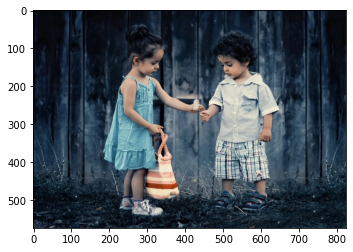

In [92]:
# 야구 이미지를 읽어 전처리 실행
test_image = './data/img5.png'
oriImg = cv2.imread(test_image)  # B,G,R 순서

# BGR을 RGB로 표시
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 이미지 resize
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 이미지 전처리
img = img.astype(np.float32) / 255.

# 색상 정보 표준화
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()  # RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （높이, 폭 색）→（색, 높이, 폭）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 이미지를 텐서로
img = torch.from_numpy(img)

# 미니 배치화: torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)


* 오픈포즈 네트워크에 전처리한 이미지 입력
* 출력결과의 히트맵과 PAFs텐서를 넘파이로 변환

In [93]:
# OpenPose로 heatmaps과 PAFs를 구한다.
net.eval()
predicted_outputs, _ = net(x)

# 이미지를 텐서에서 넘파이로 변환하여 크기 변환
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

* 왼쪾 팔꿈치와 왼쪽 손목의 히트맵, 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF 시각화

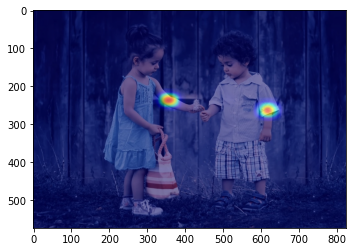

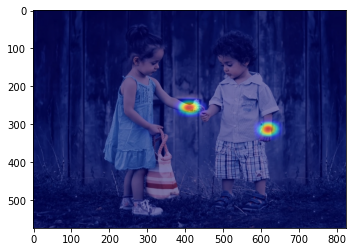

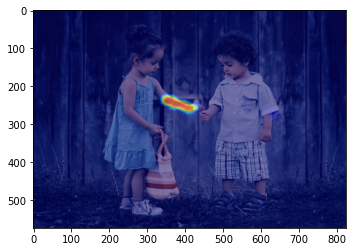

In [94]:
# 왼쪽 팔꿈치와 왼쪽 손목의 히트맵, 그리고 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x벡터를 시각화한다.
# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성하여 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성하여 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 합성하여 표시
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

* `decode_pose`
    * 인물의 각 부위를 연결하는 링크를 구하는 함수
    * 입력: 원본 이미지 히트맵, PAFs
    * 출력: 추정한 자세를 덮어쓴 이미지

In [95]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)


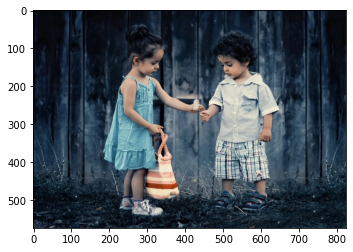

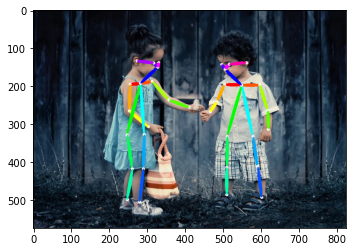

In [96]:
# 결과를 화면에 그리기
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()


<img src = "../img/OpenPose_Ex2.jpg">
<img src = "../img/OpenPose_Ex3.jpg">